## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
random.seed(0)

#### Conseguir los paths

La función consigue los caminos a los archivos de audio .wav pasándole una dirección del directorio y devolviendo el path de cada audio del dataset.

In [52]:
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files

Con la lista de paths a los audios se va a recoger las emociones que necesitemos buscándolo por el código de emoción en el nombre del archivo para su distinción.

(Es necesario conocer en qué posición está el código en el path, varía según el nivel que se encuentre en el path completo).


In [53]:
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths

def get_code_crema_d(path):
    return path[119:122]

def get_code_savee(path):
    return path[108]

Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.

In [54]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 

In [55]:
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)

La función permite cargar datos del MFCC y código desde un archivo json.

In [56]:
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples

La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 


El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.

Con el diccionario obtenemos el total de audios recuperados por emoción.


In [57]:
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples

Selecciona n ejemplos que necesitemos y los mezcla.

In [58]:
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements


Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

In [59]:
files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
emotions_code = ["NEU", "FEA","ANG"]
datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)

In [60]:
files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
emotions_code_s = ["a", "f","n"]
datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 

In [61]:
examples = []
files_filters = dict()
files_filters["NEU"] = 0
files_filters["FEA"] = 0
files_filters["ANG"] = 0
files_filters["a"] = 0
files_filters["f"] = 0
files_filters["n"] = 0

Obtenemos los MFCC con su código de emoción para posteriormente unir los datos de ambos datasets.

In [62]:
examples = get_features(datas_files, get_code_crema_d, files_filters)
examples_s = get_features(datas_files_s, get_code_savee, files_filters)
es = examples + examples_s
entries = []
for example in es:
    entries.append((example[0], example[1]))

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


Obtendremos una cantidad de datos y cambiamos las claves a los labels {"without_stress" y "stress"} posteriormente se intercambia los datos, guardamos en X los MFCC e en y los labels, estos también se categorizan.

In [63]:
entries = []
for example in es:
    entries.append((example[0], example[1]))
datas = select_elements(entries, 'NEU', 896,"without_stress")
datas += select_elements(entries, 'ANG', 550, "stress")
datas += select_elements(entries, 'FEA', 550, "stress")
datas += select_elements(entries, 'a', 60, "stress")
datas += select_elements(entries, 'f', 60, "stress")
datas += select_elements(entries, 'n', 120, "without_stress")
random.shuffle(datas)

In [64]:
X = []
y = []
for data in datas:
    X.append(data[0])
    y.append(data[1])

In [65]:
labelencoder=preprocessing.LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
y = np.array(y)

Se separa los datos en una parte para el entrenamiento y en otro para el testeo a partir de un porcentaje (0.8, 0.2).

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2,random_state=0)

In [67]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

1788 448 1788 448


In [47]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Esta es la implementación y arquitectura de la red neuronal.

In [48]:
#creacion del modelo
num_labels = y.shape[1]
dim_entrada = (X_train.shape[1],1)
    
#definiendo modelo
model = Sequential()
model.add(LSTM(units=50,input_shape= dim_entrada))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

Aqui se entrena el modelo y realizará varias iteraciones, posteriormente se puede conseguir el val_loss y el val_accuracy.

In [46]:
#numero de epocas
num_epochs = 50
num_batch_size = 32
start = datetime.datetime.now()
   
model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test))
duration = datetime.datetime.now() - start

Epoch 1/50
56/56 [==============================] - 6s 62ms/step - loss: 0.6743 - accuracy: 0.5699 - val_loss: 0.6491 - val_accuracy: 0.6138
Epoch 2/50
56/56 [==============================] - 2s 39ms/step - loss: 0.6194 - accuracy: 0.6667 - val_loss: 0.6006 - val_accuracy: 0.6384
Epoch 3/50
56/56 [==============================] - 2s 38ms/step - loss: 0.5822 - accuracy: 0.6918 - val_loss: 0.5923 - val_accuracy: 0.6406
Epoch 4/50
56/56 [==============================] - 3s 53ms/step - loss: 0.5674 - accuracy: 0.7103 - val_loss: 0.5862 - val_accuracy: 0.6473
Epoch 5/50
56/56 [==============================] - 3s 46ms/step - loss: 0.5633 - accuracy: 0.7125 - val_loss: 0.5838 - val_accuracy: 0.6518
Epoch 6/50
56/56 [==============================] - 2s 43ms/step - loss: 0.5489 - accuracy: 0.7025 - val_loss: 0.5714 - val_accuracy: 0.6518
Epoch 7/50
56/56 [==============================] - 3s 49ms/step - loss: 0.5504 - accuracy: 0.7081 - val_loss: 0.5817 - val_accuracy: 0.6629
Epoch 8/50
56

In [47]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

val_loss: 0.4840923845767975 val_accuracy: 0.7455357313156128


In [48]:
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]

14/14 [==============================] - 1s 14ms/step


In [49]:
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 

In [50]:
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

El algoritmo acerto 334 veces sobre los 448 casos.


El siguiente archivo guarda la configuración y los pesos.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk


Esta línea guarda los datos obtenidos en cada corrida.

Este bloque ejecuta todo el código que vimos.

In [85]:
examples = []
files_filters = dict()
files_filters["NEU"] = 0
files_filters["FEA"] = 0
files_filters["ANG"] = 0
files_filters["a"] = 0
files_filters["f"] = 0
files_filters["n"] = 0
start = datetime.datetime.now()
examples = get_features(datas_files, get_code_crema_d, files_filters)
examples_s = get_features(datas_files_s, get_code_savee, files_filters)
end = datetime.datetime.now() - start
print(f"transcurrio {round((end.microseconds/1000000),2)} s")
es = examples + examples_s
entries = []
for example in es:
    entries.append((example[0], example[1]))
datas = select_elements(entries, 'NEU', 896,"without_stress")
datas += select_elements(entries, 'ANG', 550, "stress")
datas += select_elements(entries, 'FEA', 550, "stress")
datas += select_elements(entries, 'a', 60, "stress")
datas += select_elements(entries, 'f', 60, "stress")
datas += select_elements(entries, 'n', 120, "without_stress")
random.shuffle(datas)
X = []
y = []
for data in datas:
    X.append(data[0])
    y.append(data[1])
labelencoder=preprocessing.LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2,random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
#creacion del modelo
num_labels = y.shape[1]
dim_entrada = (X_train.shape[1],1)
    
#definiendo modelo
model = Sequential()
model.add(LSTM(units=50,input_shape= dim_entrada))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
#numero de epocas
num_epochs = 50
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test))
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.
transcurrio 0.15 s
1788 448 1788 448
Epoch 1/50
56/56 [==============================] - 8s 61ms/step - loss: 0.6850 - accuracy: 0.5492 - val_loss: 0.6737 - val_accuracy: 0.5580
Epoch 2/50
56/56 [==============================] - 2s 40ms/step - loss: 0.6376 - accuracy: 0.6214 - val_loss: 0.5942 - val_accuracy: 0.6652
Epoch 3/50
56/56 [==============================] - 2s 43ms/step - loss: 0.5899 - accuracy: 0.6667 - val_loss: 0.5705 - val_accuracy: 0.6897
Epoch 4/50
56/56 [==============================] - 2s 41ms/step - loss: 0.5730 - accuracy: 0.6862 - val_loss: 0.5713 - val_accuracy: 0.6808
Epoch 5/50
56/56 [==============================] - 2s 42ms/step - loss: 0.5620 - accuracy: 0.6969 - val_loss: 0.5871 - val_accuracy: 0.6496
Epoch 6/50
56/56 [==============================] - 2s 40ms/step - loss: 0.5601 - accuracy: 0.6946 - val_loss: 0.5689 - val_accuracy: 0.6674
Epoch 7/50
56/56 [

In [86]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

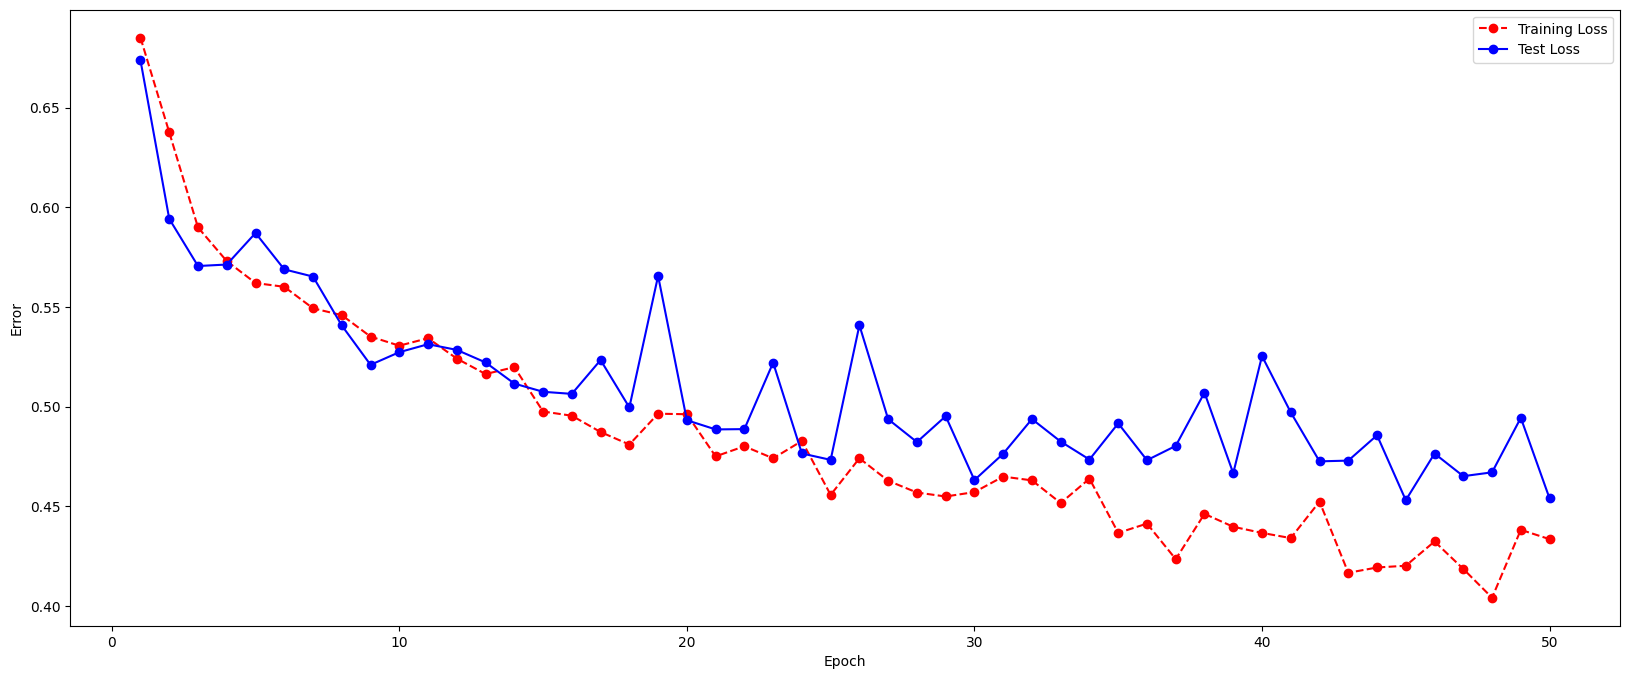

In [87]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [81]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [70]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [72]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
results = []
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    num_epochs = 50
    num_batch_size = 32

    model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test))
    
    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    results.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(pred, y_test)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in results:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1788, 40) y:(1788, 2)
Test - X:(448, 40) y:(448, 2)
Epoch 1/50
56/56 [==============================] - 4s 32ms/step - loss: 0.6782 - accuracy: 0.5419 - val_loss: 0.6572 - val_accuracy: 0.5759
Epoch 2/50
56/56 [==============================] - 1s 24ms/step - loss: 0.6258 - accuracy: 0.6387 - val_loss: 0.5950 - val_accuracy: 0.6607
Epoch 3/50
56/56 [==============================] - 1s 27ms/step - loss: 0.5935 - accuracy: 0.6801 - val_loss: 0.5605 - val_accuracy: 0.6964
Epoch 4/50
56/56 [==============================] - 1s 25ms/step - loss: 0.5724 - accuracy: 0.6818 - val_loss: 0.5475 - val_accuracy: 0.7210
Epoch 5/50
56/56 [==============================] - 1s 22ms/step - loss: 0.5732 - accuracy: 0.6991 - val_loss: 0.5386 - val_accuracy: 0.7076
Epoch 6/50
56/56 [==============================] - 1s 21ms/step - loss: 0.5586 - accuracy: 0.6935 - val_loss: 0.5349 - val_accuracy: 0.7254
Epoch 7/50
56/56 [==============================] - 1s 20ms/step - loss: 0.5372 - a

56/56 [==============================] - 1s 23ms/step - loss: 0.5526 - accuracy: 0.7071 - val_loss: 0.5315 - val_accuracy: 0.7181
Epoch 7/50
56/56 [==============================] - 1s 24ms/step - loss: 0.5491 - accuracy: 0.7026 - val_loss: 0.5197 - val_accuracy: 0.7248
Epoch 8/50
56/56 [==============================] - 1s 22ms/step - loss: 0.5375 - accuracy: 0.7160 - val_loss: 0.5261 - val_accuracy: 0.7204
Epoch 9/50
56/56 [==============================] - 1s 23ms/step - loss: 0.5346 - accuracy: 0.7116 - val_loss: 0.5008 - val_accuracy: 0.7383
Epoch 10/50
56/56 [==============================] - 1s 23ms/step - loss: 0.5375 - accuracy: 0.7160 - val_loss: 0.5081 - val_accuracy: 0.7226
Epoch 11/50
56/56 [==============================] - 1s 23ms/step - loss: 0.5236 - accuracy: 0.7222 - val_loss: 0.5051 - val_accuracy: 0.7271
Epoch 12/50
56/56 [==============================] - 1s 23ms/step - loss: 0.5145 - accuracy: 0.7401 - val_loss: 0.4953 - val_accuracy: 0.7383
Epoch 13/50
56/56 [==

Epoch 12/50
56/56 [==============================] - 1s 24ms/step - loss: 0.5106 - accuracy: 0.7401 - val_loss: 0.5157 - val_accuracy: 0.7159
Epoch 13/50
56/56 [==============================] - 1s 24ms/step - loss: 0.4968 - accuracy: 0.7446 - val_loss: 0.5154 - val_accuracy: 0.7204
Epoch 14/50
56/56 [==============================] - 1s 24ms/step - loss: 0.5198 - accuracy: 0.7239 - val_loss: 0.5179 - val_accuracy: 0.7271
Epoch 15/50
56/56 [==============================] - 2s 27ms/step - loss: 0.4918 - accuracy: 0.7507 - val_loss: 0.5178 - val_accuracy: 0.7360
Epoch 16/50
56/56 [==============================] - 1s 26ms/step - loss: 0.4801 - accuracy: 0.7462 - val_loss: 0.5144 - val_accuracy: 0.7025
Epoch 17/50
56/56 [==============================] - 2s 29ms/step - loss: 0.4824 - accuracy: 0.7507 - val_loss: 0.5359 - val_accuracy: 0.7315
Epoch 18/50
56/56 [==============================] - 1s 26ms/step - loss: 0.4837 - accuracy: 0.7462 - val_loss: 0.4883 - val_accuracy: 0.7383
Epoch 

Epoch 18/50
56/56 [==============================] - 1s 26ms/step - loss: 0.4576 - accuracy: 0.7624 - val_loss: 0.4838 - val_accuracy: 0.7517
Epoch 19/50
56/56 [==============================] - 2s 27ms/step - loss: 0.4651 - accuracy: 0.7652 - val_loss: 0.4680 - val_accuracy: 0.7472
Epoch 20/50
56/56 [==============================] - 1s 26ms/step - loss: 0.4828 - accuracy: 0.7541 - val_loss: 0.5209 - val_accuracy: 0.7204
Epoch 21/50
56/56 [==============================] - 1s 23ms/step - loss: 0.4629 - accuracy: 0.7535 - val_loss: 0.4628 - val_accuracy: 0.7606
Epoch 22/50
56/56 [==============================] - 1s 22ms/step - loss: 0.4537 - accuracy: 0.7731 - val_loss: 0.4737 - val_accuracy: 0.7494
Epoch 23/50
56/56 [==============================] - 1s 22ms/step - loss: 0.4378 - accuracy: 0.7837 - val_loss: 0.4496 - val_accuracy: 0.7718
Epoch 24/50
56/56 [==============================] - 1s 22ms/step - loss: 0.4664 - accuracy: 0.7675 - val_loss: 0.4625 - val_accuracy: 0.7696
Epoch 

Epoch 24/50
56/56 [==============================] - 1s 20ms/step - loss: 0.4545 - accuracy: 0.7691 - val_loss: 0.4557 - val_accuracy: 0.7562
Epoch 25/50
56/56 [==============================] - 1s 20ms/step - loss: 0.4413 - accuracy: 0.7759 - val_loss: 0.4925 - val_accuracy: 0.7360
Epoch 26/50
56/56 [==============================] - 1s 20ms/step - loss: 0.4717 - accuracy: 0.7613 - val_loss: 0.5234 - val_accuracy: 0.6935
Epoch 27/50
56/56 [==============================] - 1s 20ms/step - loss: 0.4412 - accuracy: 0.7686 - val_loss: 0.5215 - val_accuracy: 0.7271
Epoch 28/50
56/56 [==============================] - 1s 19ms/step - loss: 0.4408 - accuracy: 0.7781 - val_loss: 0.4749 - val_accuracy: 0.7651
Epoch 29/50
56/56 [==============================] - 1s 20ms/step - loss: 0.4165 - accuracy: 0.7965 - val_loss: 0.4534 - val_accuracy: 0.7808
Epoch 30/50
56/56 [==============================] - 1s 20ms/step - loss: 0.4392 - accuracy: 0.7820 - val_loss: 0.4535 - val_accuracy: 0.7629
Epoch 

In [35]:
'''
Cross-validated score (Accuracy score): 0.7874720357941835
-----------------------
Resumen
Fold score (Accuracy score): 0.8169642857142857
Fold score (Accuracy score): 0.7651006711409396
Fold score (Accuracy score): 0.7695749440715883
Fold score (Accuracy score): 0.7427293064876958
Fold score (Accuracy score): 0.7874720357941835

Cross-validated score (Accuracy score): 0.7986577181208053
-----------------------
Resumen
Fold score (Accuracy score): 0.8080357142857143
Fold score (Accuracy score): 0.7718120805369127
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7762863534675615
Fold score (Accuracy score): 0.7986577181208053


Cross-validated score (Accuracy score): 0.785234899328859
-----------------------
Resumen
Fold score (Accuracy score): 0.7276785714285714
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.7516778523489933
Fold score (Accuracy score): 0.8031319910514542
Fold score (Accuracy score): 0.785234899328859

Cross-validated score (Accuracy score): 0.7919463087248322
-----------------------
Resumen
Fold score (Accuracy score): 0.6741071428571429
Fold score (Accuracy score): 0.7897091722595079
Fold score (Accuracy score): 0.7628635346756152
Fold score (Accuracy score): 0.7583892617449665
Fold score (Accuracy score): 0.7919463087248322

Cross-validated score (Accuracy score): 0.796420581655481
-----------------------
Resumen
Fold score (Accuracy score): 0.734375
Fold score (Accuracy score): 0.7606263982102909
Fold score (Accuracy score): 0.756152125279642
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.796420581655481

Cross-validated score (Accuracy score): 0.7606263982102909
-----------------------
Resumen
Fold score (Accuracy score): 0.7946428571428571
Fold score (Accuracy score): 0.7785234899328859
Fold score (Accuracy score): 0.7651006711409396
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7606263982102909

Cross-validated score (Accuracy score): 0.7829977628635347
-----------------------
Resumen
Fold score (Accuracy score): 0.8058035714285714
Fold score (Accuracy score): 0.7583892617449665
Fold score (Accuracy score): 0.738255033557047
Fold score (Accuracy score): 0.7785234899328859
Fold score (Accuracy score): 0.7829977628635347

Cross-validated score (Accuracy score): 0.796420581655481
-----------------------
Resumen
Fold score (Accuracy score): 0.8169642857142857
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7695749440715883
Fold score (Accuracy score): 0.796420581655481

Cross-validated score (Accuracy score): 0.7539149888143176
-----------------------
Resumen
Fold score (Accuracy score): 0.8125
Fold score (Accuracy score): 0.7651006711409396
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.756152125279642
Fold score (Accuracy score): 0.7539149888143176

Cross-validated score (Accuracy score): 0.796420581655481
-----------------------
Resumen
Fold score (Accuracy score): 0.8058035714285714
Fold score (Accuracy score): 0.7606263982102909
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.796420581655481
'''



'\nCross-validated score (Accuracy score): 0.7874720357941835\n-----------------------\nResumen\nFold score (Accuracy score): 0.8169642857142857\nFold score (Accuracy score): 0.7651006711409396\nFold score (Accuracy score): 0.7695749440715883\nFold score (Accuracy score): 0.7427293064876958\nFold score (Accuracy score): 0.7874720357941835\n\nCross-validated score (Accuracy score): 0.7986577181208053\n-----------------------\nResumen\nFold score (Accuracy score): 0.8080357142857143\nFold score (Accuracy score): 0.7718120805369127\nFold score (Accuracy score): 0.7874720357941835\nFold score (Accuracy score): 0.7762863534675615\nFold score (Accuracy score): 0.7986577181208053\n\n\nCross-validated score (Accuracy score): 0.785234899328859\n-----------------------\nResumen\nFold score (Accuracy score): 0.7276785714285714\nFold score (Accuracy score): 0.785234899328859\nFold score (Accuracy score): 0.7516778523489933\nFold score (Accuracy score): 0.8031319910514542\nFold score (Accuracy scor